# Analysis and prediction of Crime data as it relates to weather conditions in the city of San Francisco

- Jim Haskin

- GA-Data Science
- Dec 2015

- 2/17/2016

## Hypothesis
It is often said that people lose their temper more when it is hot out and that all the crazies come out when there is a full moon. But does the data prove these hunches are true? 
If it is true, can we look at the weather forecast for the next week and predict if the number or intensity of Police Incidents will be higher or lower than usual?

## Method
Crime Data - This was done in the `'2_clean_data_sf_crime'` notebook.
- I have collected the incident reports of the San Franciso Police Department from the SF OpenData website. https://data.sfgov.org/data?category=Public%20Safety. I have the records from January, 2003 until the beginning of 2016.
- I summerized the report to generate a daily report of the number of incidents and another factor I am calling Crime Level. Each incident is given a score based on how violent it is. Murders and assaults are rated high. Traffic violations and non-criminal incidents are rated low. These scores are summed and then normalized to a scale of 0 - 10.
- Data written to file. `'sf_crime_clean.csv'`

Weather Data - Done in the `'3_clean_weather_combine_with_crime'` notebook
- I collected historical weather data for the San Franciso area from January 2003 until December 2015. The data comes from Weather Underground. http://www.wunderground.com/history/
- To that data I added new calculated features, such as the phase of the moon, wind chill and heat index that I thought might be relavent.
- Data written to file. `'sf_weather_clean.csv'`
- The weather data and crime data were merged and written to the file. `'sf_crime_weather.csv'`

Analysis and Cleaning - Done in the `'5_analysis_cleaning'` notebook
- I looked at the crime levels as it related to different features to get a general idea of what features are important.
- Removed outliers
- Removed fields that are not in the Forecast Data that will be used for prediction.
- Created new Features for the categorical data.(rain, end_of_week, winter)
- Final data was written to the file. `'sf_crime_weather_clean.csv'`

Forecast - Done in the `'8_get_weather_forecast'` notebook.
- I used the WeatherUnderground API and the OpenWeatherMap API to retreive the forecast for the next 10 days in San Fransico.
- To this I added in the other relavent features such as Moon Phase.
- Data is written to file. `'forecast_10day.csv'`
- This new data is then run throught the model to predict the general level of crime for the next 10 days.

Modeling and Prediction- Done in the `'SF_final_crime_and_weather_JFH'`
- Build Model.......
- ...........




## Sections

- [Data Source Definition](#Data-source-Definition)
- [Prepare Data](#Prepare-Data)
- - [Catagoricals](#Catagoricals)
- - [Select Features](#Select-Features)
- [Dummy Regressor](#Dummy-Regressor)
- [Random Forest](#Random-Forests)
- [SVM](#SVM)
- [Lasso/Ridge](#Lasso/Ridge)
- [knn](#knn)
- [Forecast](#Forecast)
- - [Add Engineered Features](#Add-Engineered-Features)
- - [Run Models on Prediction](#Run-Models-on-Prediction)
- [Results](#Results)
- [Change Log](#Change-Log)
- [To Try](#To-Try)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
# use fivethirtyeight style for all graphics
plt.style.use('fivethirtyeight')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sk_modelcurves.learning_curve import draw_learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

## Data source Definition

[[back to top](#Sections)]


Data was consolidated in these two Notebooks
- '2_clean_data_sf_crime.ipynb' | Data downloaded from SF Open Data site. 
- '3_clean_weather_combine_with_crime.ipynb' | Data downloaded from WeatherUnderground.com
- It was then analysed, cleaned and had Features Engineered in the '5_analysis.ipynb' notebook
- Final file name 'sf_crime_weather_clean.csv'


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
crime_level_sum|int64|Calculated Crime Level for the day
crime_count|int64|Number of incidents for the day
weather_crime_count|int64|Number of incidents related to weather for the day
violent_crime_count|int64|Number of incidents I labled violent for the day
COP_count|int64|Number of incidents  I labled CrimeOfPassion for the day
gun_crime_count|int64|Number of incidents for the day
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
crime_level|float64|Crime level scaled to 0-10
weather_crime_level|float64|Crimes influenced by weather level scaled to 0-10
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
dew_point_max|int64|High Dew Point for the day in degrees F
dew_point_mean|int64|Mean Dew Point for the day in degrees F
dew_point_min|int64|Low Dew Point for the day in degrees F
humidity_max|int64|Maximum Humidity for the day in percentage
humidity_mean|int64|Mean Humidity for the day in percentage
humidity_min|int64|Minimum Humidity for the day in percentage
sl_pressure_max|float64|High Sea Level for the day in inches
sl_pressure_mean|float64|Mean Sea Level for the day in inches
sl_pressure_min|float64|Low Sea Level for the day in inches
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
wind_max_gust|float64|Maximum Wind Gust in mph
precipitation|float64|Amount is precipitation in inches
cloud_cover|int64|Cloud Cover in percentage
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
wind_chill_mean|int64|calculated mean of wind chill using temp and wind speed
wind_chill_max|int64|calculated max of wind chill
heat_index|float64|calculated heat_index using temp, humidity and dewpoint
temp_apparent|float64|calculated Apparent temperature using temp humidity and windspeed
end_of_week|category|Boolean for if it is a Friday or Saturday
winter|category|Boolean for if it is a winter month       
rain|category|Boolean for if it rained or not                

# Prepare Data

[[back to top](#Sections)]


## Read in combined Data 
    

In [5]:
data = pd.read_csv('sf_crime_weather_clean.csv', index_col=0)
#data = pd.read_csv('sf_crime_weather_violent.csv', index_col=0)
data.head(2)

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,dayofweek,day,month,year,...,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent,end_of_week,winter,rain
2011-02-19,642,350,65,30,42,3,saturday,19,2,2011,...,659.533333,0.546709,85.739333,43,45,105.910373,58.363068,True,False,True
2005-01-13,761,400,69,35,71,3,thursday,13,1,2005,...,590.783333,0.097609,147.695833,44,46,131.917614,65.307872,False,False,False


### Catagoricals

[[back to top](#Sections)]


In [6]:
# Set the Categorical feature to the correct type
data['events'] = data['events'].astype('category')
data['day'] = data['day'].astype('category')
data['month'] = data['month'].astype('category')
data['year'] = data['year'].astype('category')
data['dayofweek'] = data['dayofweek'].astype('category')
data['end_of_week'] = data['end_of_week'].astype('category')
data['rain'] = data['rain'].astype('category')
data['winter'] = data['winter'].astype('category')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4745 entries, 2011-02-19 to 2010-08-24
Data columns (total 42 columns):
crime_level_sum        4745 non-null int64
crime_count            4745 non-null int64
weather_crime_count    4745 non-null int64
violent_count          4745 non-null float64
COP_count              4745 non-null float64
gun_crime_count        4745 non-null float64
dayofweek              4745 non-null category
day                    4745 non-null category
month                  4745 non-null category
year                   4745 non-null category
crime_level            4745 non-null float64
weather_crime_level    4745 non-null float64
temp_max               4745 non-null int64
temp_mean              4745 non-null int64
temp_min               4745 non-null int64
temp_delta             4745 non-null int64
dew_point_max          4745 non-null int64
dew_point_mean         4745 non-null float64
dew_point_min          4745 non-null int64
humidity_max           4745 non-null int64

In [8]:
data.describe()

,crime_level_sum,crime_count,weather_crime_count,violent_count,COP_count,gun_crime_count,crime_level,weather_crime_level,temp_max,temp_mean,...,precipitation,cloud_cover,wind_direction,sun_length,moon_phase,sun_units,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
count,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,...,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000,4745.000000
mean,720.585669,382.032666,77.934879,39.756164,60.809062,3.313804,4.815569,4.281063,65.849947,58.662803,...,0.047181,44.920759,246.122234,732.011640,0.512256,406.803915,58.662803,65.849947,216.646295,93.021698
std,87.805220,46.288691,13.882995,9.260436,11.259500,2.130232,0.986576,0.991642,8.402315,6.530743,...,0.191603,28.926472,71.727288,106.738169,0.288648,223.377818,6.530743,8.402315,60.304576,18.359682
min,292.000000,148.000000,18.000000,6.000000,18.000000,0.000000,0.000000,0.000000,45.000000,40.000000,...,0.000000,0.000000,1.000000,575.300000,0.012958,0.000000,40.000000,45.000000,55.000000,38.602076
25%,662.000000,352.000000,68.000000,34.000000,53.000000,2.000000,4.157303,3.571429,60.000000,54.000000,...,0.000000,25.000000,235.000000,628.583333,0.262623,219.329167,54.000000,60.000000,172.486051,79.344245
50%,718.000000,381.000000,77.000000,39.000000,60.000000,3.000000,4.786517,4.214286,65.000000,59.000000,...,0.000000,50.000000,273.000000,733.233333,0.510797,412.583333,59.000000,65.000000,219.701946,92.693869
75%,776.000000,412.000000,86.000000,45.000000,68.000000,5.000000,5.438202,4.857143,71.000000,63.000000,...,0.000000,75.000000,290.000000,835.733333,0.761123,579.466667,63.000000,71.000000,259.600068,105.415039
max,1182.000000,579.000000,158.000000,91.000000,134.000000,16.000000,10.000000,10.000000,99.000000,82.000000,...,3.430000,100.000000,359.000000,885.650000,1.012482,885.633333,82.000000,99.000000,429.726716,161.898428


In [9]:
# Data Frame to hold results. To compare models after all are run
results = pd.DataFrame(index=['dummy', 'RF', 'SVM', 'LR', 'knn'], 
                       columns=['mean_abs_error', 'R2_score','time','lc_com'])

## Select Features

[[back to top](#Sections)]


In [10]:
data.columns

Index([u'crime_level_sum', u'crime_count', u'weather_crime_count',
       u'violent_count', u'COP_count', u'gun_crime_count', u'dayofweek',
       u'day', u'month', u'year', u'crime_level', u'weather_crime_level',
       u'temp_max', u'temp_mean', u'temp_min', u'temp_delta', u'dew_point_max',
       u'dew_point_mean', u'dew_point_min', u'humidity_max', u'humidity_mean',
       u'humidity_min', u'sl_pressure_max', u'sl_pressure_mean',
       u'sl_pressure_min', u'wind_speed_max', u'wind_speed_mean',
       u'wind_max_gust', u'precipitation', u'cloud_cover', u'events',
       u'wind_direction', u'sun_length', u'moon_phase', u'sun_units',
       u'wind_chill_mean', u'wind_chill_max', u'heat_index', u'temp_apparent',
       u'end_of_week', u'winter', u'rain'],
      dtype='object')

### Review Correlations
- Temperature features (temp, dewpoint, wind chill, heat index are very correlated)

In [11]:
data[[u'temp_max', u'temp_mean', u'temp_delta', u'temp_apparent',
       u'dew_point_mean', u'humidity_mean',
       u'wind_chill_mean', u'heat_index', 
       u'sl_pressure_mean', u'wind_speed_mean']].corr()

,temp_max,temp_mean,temp_delta,temp_apparent,dew_point_mean,humidity_mean,wind_chill_mean,heat_index,sl_pressure_mean,wind_speed_mean
temp_max,1.000000,0.950802,0.734774,0.852066,0.746200,-0.440581,0.950802,0.696387,-0.363531,0.059838
temp_mean,0.950802,1.000000,0.492378,0.930171,0.872325,-0.294023,1.000000,0.826268,-0.450244,0.173376
temp_delta,0.734774,0.492378,1.000000,0.360566,0.185097,-0.618694,0.492378,0.144109,-0.032472,-0.212390
temp_apparent,0.852066,0.930171,0.360566,1.000000,0.957028,0.013004,0.930171,0.943559,-0.408187,-0.003510
dew_point_mean,0.746200,0.872325,0.185097,0.957028,1.000000,0.205574,0.872325,0.982994,-0.465238,0.179687
humidity_mean,-0.440581,-0.294023,-0.618694,0.013004,0.205574,1.000000,-0.294023,0.257262,0.000034,-0.033173
wind_chill_mean,0.950802,1.000000,0.492378,0.930171,0.872325,-0.294023,1.000000,0.826268,-0.450244,0.173376
heat_index,0.696387,0.826268,0.144109,0.943559,0.982994,0.257262,0.826268,1.000000,-0.441332,0.169122
sl_pressure_mean,-0.363531,-0.450244,-0.032472,-0.408187,-0.465238,0.000034,-0.450244,-0.441332,1.000000,-0.373138
wind_speed_mean,0.059838,0.173376,-0.212390,-0.003510,0.179687,-0.033173,0.173376,0.169122,-0.373138,1.000000


#### Several different combinations that can be tried

In [ ]:
# All numeric features + 
all_features = ['temp_max', 'temp_mean', 'temp_min',
       'temp_delta',  'dew_point_mean', 
       'humidity_mean', 'sl_pressure_mean',
       'wind_chill_max', 'wind_chill_mean', 'winter',
       'wind_speed_max', 'wind_speed_mean', 'precipitation', 'cloud_cover',
       'wind_direction', 'sun_length', 'moon_phase',
       'sun_units', 'end_of_week', 'rain','temp_apparent', 'heat_index']

In [ ]:
# Day and date info only
date_features = [ 'dayofweek', 'month', 'day']
      

In [ ]:
# Star features with the lasso zeroed out features removed
Reduced_features = [ 'cloud_cover', 'dayofweek', 'month',   'sun_length', 'day',
       'temp_delta',  'temp_apparent', 'rain', 
       'humidity_mean', 'sl_pressure_mean']

In [ ]:
# features indicated by RF  
RF_features = ['temp_mean', 'temp_delta', 'dew_point_mean', 'humidity_mean', 'sl_pressure_mean',
            'wind_speed_mean', 'cloud_cover', 'wind_direction', 'sun_length',
            'wind_chill_mean', 'heat_index', 'temp_apparent',
             'rain', 'dayofweek', 'month', 'day',
            'sun_units', 'moon_phase']





#### The Current set of features to try

In [12]:
# Current best combination to run
features = ['temp_mean', 'temp_delta', 'dew_point_mean', 'humidity_mean', 'sl_pressure_mean',
            'wind_speed_mean', 'cloud_cover', 'wind_direction', 'sun_length',
            'wind_chill_mean', 'heat_index', 'temp_apparent',
            'rain', 'dayofweek', 'month', 'day']


### Choose which Crime Variable to train to

In [13]:
# Which class to train to
#label = 'crime_count'
#label = 'violent_count'
#label = 'crime_level_sum'
label = 'COP_count'
dummy_drop = ['dayofweek_monday', 'month_1', 'rain_False', 'day_3']
#dummy_drop = ['rain_False', 'end_of_week_False']

In [14]:
# split into data and class  X, y
X, y = data[features], data[label]
X.head()

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,heat_index,temp_apparent,rain,dayofweek,month,day
2011-02-19,43,5,39.468602,83,29.80,6,87,38,659.533333,43,105.910373,58.363068,True,saturday,2,19
2005-01-13,44,5,42.808950,94,30.29,4,75,82,590.783333,44,131.917614,65.307872,False,thursday,1,13
2009-12-09,41,10,34.666876,71,30.14,7,50,77,579.450000,41,78.045786,50.248217,False,wednesday,12,9
2007-01-12,42,9,29.035540,49,30.16,18,0,347,588.933333,42,60.787461,38.602076,False,friday,1,12
2008-01-24,44,5,40.215304,82,29.75,10,87,130,606.100000,44,111.541230,57.519633,True,thursday,1,24


### Create the dummies from the categorical features

In [15]:
# use get_dummies to convert categoricals into binary features
X = pd.get_dummies(X)
X.head(2)

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2011-02-19,43,5,39.468602,83,29.80,6,87,38,659.533333,43,...,0,0,0,0,0,0,0,0,0,0
2005-01-13,44,5,42.808950,94,30.29,4,75,82,590.783333,44,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# save the full list if features including the new dummies
# will be needed to create the forecast data frame to run through predictions
full_features = X.columns

In [17]:
# Drop one feature for each categorical
X.drop(dummy_drop, axis=1, inplace=True)
X.head(2)

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2011-02-19,43,5,39.468602,83,29.80,6,87,38,659.533333,43,...,0,0,0,0,0,0,0,0,0,0
2005-01-13,44,5,42.808950,94,30.29,4,75,82,590.783333,44,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4745 entries, 2011-02-19 to 2010-08-24
Data columns (total 60 columns):
temp_mean              4745 non-null int64
temp_delta             4745 non-null int64
dew_point_mean         4745 non-null float64
humidity_mean          4745 non-null int64
sl_pressure_mean       4745 non-null float64
wind_speed_mean        4745 non-null int64
cloud_cover            4745 non-null int64
wind_direction         4745 non-null int64
sun_length             4745 non-null float64
wind_chill_mean        4745 non-null int64
heat_index             4745 non-null float64
temp_apparent          4745 non-null float64
rain_True              4745 non-null float64
dayofweek_friday       4745 non-null float64
dayofweek_saturday     4745 non-null float64
dayofweek_sunday       4745 non-null float64
dayofweek_thursday     4745 non-null float64
dayofweek_tuesday      4745 non-null float64
dayofweek_wednesday    4745 non-null float64
month_2                4745 non-null float

### Split into Test and Training

In [19]:
# Split up data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [20]:
# Standardize data if needed
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [21]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

### Scoring Metric

In [22]:
# Choose the scoring metric
scoring='mean_absolute_error'
#scoring='r2'

## Dummy Regressor
- used to compair models to the dummy, which just chooses the mean everytime.

[[back to top](#Sections)]


In [23]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train_std, y_train)
scores = cross_val_score(dummy_model, X_train_std, y_train, scoring=scoring, cv=cv)
print('CV MEA {}, Average MEA {}'.format(scores, scores.mean()))

CV MEA [-8.80868005 -8.50122044 -9.08180345 -8.44095243 -9.01609718 -8.90513747
 -8.60242528 -8.76113654 -8.62928108 -8.47338863], Average MEA -8.72201225643


In [24]:
# Get Mean Error of the test set
results.loc['dummy','mean_abs_error'] = mean_absolute_error(y_test, dummy_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['dummy','mean_abs_error']   

Mean Absolute Error =  9.08841706816


In [25]:
results.loc['dummy','R2_score'] = dummy_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['dummy','R2_score']

Model R2_score :  -0.00331671859043


In [26]:
# Check the Speed of esimator
time = %timeit -o dummy_model.predict(X_test_std)
print time
results.loc['dummy','time'] = time.best * 1000000

10000 loops, best of 3: 55.3 µs per loop


## Random Forests

[[back to top](#Sections)]


In [27]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [28]:
ests = range(40,171,20)
for est in ests:
    model = RandomForestRegressor(n_estimators = est)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
    print('n_est {}, CV MAE {}, Average MAE {}'.format(est, scores, scores.mean() * -1))

n_est 40, CV MAE [-8.39243421 -8.28059211 -8.44930921 -8.26230263 -8.60851974], Average MAE 8.39863157895
n_est 60, CV MAE [-8.19057018 -8.26403509 -8.41721491 -8.17133772 -8.6345614 ], Average MAE 8.33554385965
n_est 80, CV MAE [-8.185625   -8.22802632 -8.40513158 -8.08554276 -8.56557566], Average MAE 8.29398026316
n_est 100, CV MAE [-8.22284211 -8.16321053 -8.38310526 -8.17942105 -8.60369737], Average MAE 8.31045526316
n_est 120, CV MAE [-8.20200658 -8.246875   -8.39695175 -8.13814693 -8.55239035], Average MAE 8.30727412281
n_est 140, CV MAE [-8.19558271 -8.22106203 -8.37074248 -8.11177632 -8.55152256], Average MAE 8.29013721805
n_est 160, CV MAE [-8.18098684 -8.22242599 -8.42806743 -8.1342023  -8.59100329], Average MAE 8.31133717105


In [29]:
X_features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': X_features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
8,sun_length,0.126718
7,wind_direction,0.086198
4,sl_pressure_mean,0.071358
11,temp_apparent,0.069255
1,temp_delta,0.065661
3,humidity_mean,0.063415
5,wind_speed_mean,0.056339
10,heat_index,0.044819
2,dew_point_mean,0.042527
6,cloud_cover,0.039569


### Choose final parms and fit

In [30]:
RF_model = RandomForestRegressor(n_estimators = 140)
RF_model.fit(X_train, y_train)
scores = cross_val_score(RF_model, X_train, y_train, scoring=scoring, cv=cv)
print('n_est {}, CV MAE {}, MAE accuracy {}'.format(est, scores, scores.mean() * -1))

n_est 160, CV MAE [-8.22080827 -8.19824248 -8.35065789 -8.14866541 -8.59405075], MAE accuracy 8.30248496241


/Users/jsmithson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


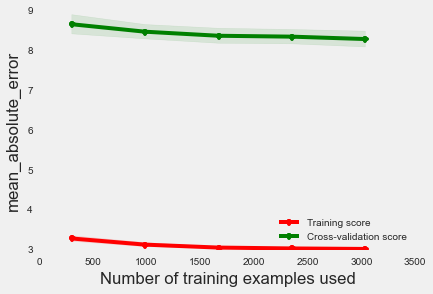

In [31]:
draw_learning_curve(RF_model, X_train, y_train, estimator_titles=['Learning Curve for RF. Best'], 
                    cv=cv, scoring=scoring);

In [32]:
results.loc['RF','lc_com'] = '.......'

In [33]:
# Get Mean Error of the test set
results.loc['RF','mean_abs_error'] = mean_absolute_error(y_test, RF_model.predict(X_test))
print 'Mean Absolute Error = ', results.loc['RF','mean_abs_error']   

Mean Absolute Error =  8.65672888755


In [34]:
results.loc['RF','R2_score'] = RF_model.score(X_test, y_test)
print 'Model R2_score : ', results.loc['RF','R2_score']

Model R2_score :  0.104778507796


In [35]:
# Check the Speed of esimator
time = %timeit -o RF_model.predict(X_test)
print time
results.loc['RF','time'] = time.best * 1000000

10 loops, best of 3: 27.5 ms per loop


## SVM


[[back to top](#Sections)]


In [36]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [37]:
#SVM_model = SVR(C=10, kernel='rbf', gamma=.001, degree=1)
#SVM_model.fit(X_train_std, y_train)

In [38]:
np.linspace(.5, 2, 4)

array([ 0.5,  1. ,  1.5,  2. ])

In [47]:
#params = {'C': np.linspace(1, 7, 4), 'kernel': ['poly', 'rbf'],
#         'degree': range(1,3), 'gamma': np.linspace(.001, 10, 2)}
# 1 params = {'kernel': ['poly', 'rbf', 'sigmoid', 'linear'], 'degree': range(1,4)}

#params = {'C': np.linspace(.01, 2, 10), 'kernel': ['linear']}


params = {'C': np.linspace(.01, 1, 10), 'kernel': ['linear']}



clf = SVR()
grid = GridSearchCV(clf, params, cv=cv, scoring=scoring, n_jobs=-1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=ShuffleSplit(3796, n_iter=5, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'kernel': ['linear'], 'C': array([ 0.01,  0.12,  0.23,  0.34,  0.45,  0.56,  0.67,  0.78,  0.89,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [48]:
grid.best_params_

{'C': 0.12, 'kernel': 'linear'}

In [49]:
grid.grid_scores_

[mean: -8.31162, std: 0.20609, params: {'kernel': 'linear', 'C': 0.01},
 mean: -8.30294, std: 0.16817, params: {'kernel': 'linear', 'C': 0.12},
 mean: -8.30704, std: 0.16564, params: {'kernel': 'linear', 'C': 0.23000000000000001},
 mean: -8.30924, std: 0.16321, params: {'kernel': 'linear', 'C': 0.34000000000000002},
 mean: -8.31107, std: 0.16134, params: {'kernel': 'linear', 'C': 0.45000000000000001},
 mean: -8.31103, std: 0.16125, params: {'kernel': 'linear', 'C': 0.56000000000000005},
 mean: -8.31150, std: 0.16044, params: {'kernel': 'linear', 'C': 0.67000000000000004},
 mean: -8.31093, std: 0.16019, params: {'kernel': 'linear', 'C': 0.78000000000000003},
 mean: -8.31097, std: 0.15958, params: {'kernel': 'linear', 'C': 0.89000000000000001},
 mean: -8.31134, std: 0.15924, params: {'kernel': 'linear', 'C': 1.0}]

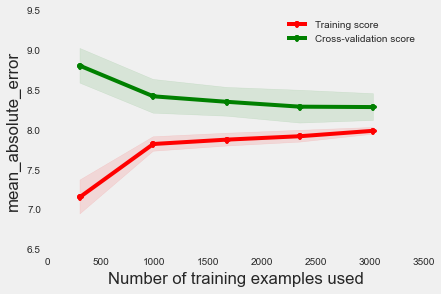

In [50]:
SVM_model = grid.best_estimator_

draw_learning_curve(SVM_model, X_train_std, y_train, estimator_titles=['Learning Curve for SVC. Best'], 
                    cv=cv, scoring=scoring);

In [51]:
results.loc['SVM','lc_com'] = '.......'

In [52]:
results.loc['SVM','R2_score'] = SVM_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['SVM','R2_score']

Model R2_score :  0.0904152987343


In [53]:
# Get Mean Error of the test set
results.loc['SVM','mean_abs_error'] = mean_absolute_error(y_test, SVM_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['SVM','mean_abs_error']            

Mean Absolute Error =  8.6772758242


In [54]:
# Check the Speed of esimator
time = %timeit -o SVM_model.predict(X_test_std)
print time
results.loc['SVM','time'] = time.best * 1000000

1 loops, best of 3: 190 ms per loop


## Lasso/Ridge

[[back to top](#Sections)]


In [55]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train_std.shape[0], n_iter=20, test_size=0.2, random_state=0)

In [56]:
# using Mean Absolute scoring
parameters = {'alpha': np.linspace(.01,1,20)}
LR = Lasso(normalize=False)
clf = GridSearchCV(LR, parameters, scoring=scoring, cv=cv)
clf.fit(X_train_std, y_train)
clf.best_params_

{'alpha': 0.11421052631578947}

In [59]:
#clf.grid_scores_

In [60]:
LR_model = clf.best_estimator_

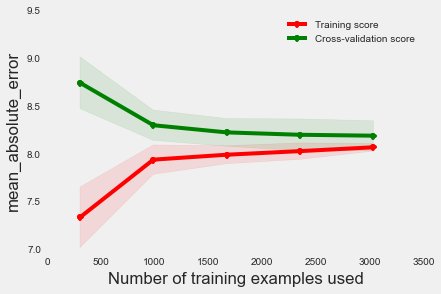

In [61]:
draw_learning_curve(LR_model, X_train_std, y_train, estimator_titles=['Learning Curve for lasso'], 
                    cv=cv, scoring=scoring);

In [62]:
results.loc['LR','lc_com'] = '.......'

In [63]:
results.loc['LR','R2_score'] = LR_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['LR','R2_score']

Model R2_score :  0.110640706897


In [64]:
# Get Mean Error of the test set
results.loc['LR','mean_abs_error'] = mean_absolute_error(y_test, LR_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['LR','mean_abs_error']             

Mean Absolute Error =  8.61711715431


In [65]:
# Check the Speed of esimator
time = %timeit -o LR_model.predict(X_test_std)
print time
results.loc['LR','time'] = time.best * 1000000

10000 loops, best of 3: 76.8 µs per loop


In [66]:
# create a dataframe to show our coefficients
d = {'features': X_test.columns, 'coefficients': LR_model.coef_}
pd.DataFrame(d)

,coefficients,features
0,0.546365,temp_mean
1,0.061243,temp_delta
2,0.000000,dew_point_mean
3,-0.313258,humidity_mean
4,0.000000,sl_pressure_mean
5,-0.173353,wind_speed_mean
6,-0.000000,cloud_cover
7,0.000000,wind_direction
8,-0.183891,sun_length
9,0.012546,wind_chill_mean


## knn

[[back to top](#Sections)]


In [67]:
# Create the cv - defines how you want to break up all the tests
cv = ShuffleSplit(X_train_std.shape[0], n_iter=5, test_size=0.2, random_state=0)

In [68]:
# Can be any estimator
knn = KNeighborsRegressor()

In [69]:
# Run estimator for all parameter combinations
parameters = {'n_neighbors': range(1,10), 'weights': ['uniform', 'distance'],'p': range(1,4)}
#parameters = {'n_neighbors': range(1,20), 'weights': ['uniform', 'distance'],'p': range(1,4)}
clf = GridSearchCV(knn, parameters, cv=cv)
clf.fit(X_train_std, y_train)
clf.best_params_

{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}

In [70]:
knn_model = clf.best_estimator_

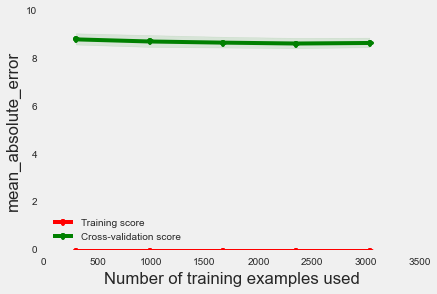

In [71]:
draw_learning_curve(knn_model, X_train_std, y_train, estimator_titles=['Learning Curve for knn'], 
                    cv=cv, scoring=scoring);

In [72]:
results.loc['knn','lc_com'] = '.......'

In [73]:
# Find out Score for actual data
results.loc['knn','R2_score'] = knn_model.score(X_test_std, y_test)
print 'Model R2_score : ', results.loc['knn','R2_score']

Model R2_score :  0.0282406186444


In [74]:
# Get Mean Error of the test set
results.loc['knn','mean_abs_error'] = mean_absolute_error(y_test, knn_model.predict(X_test_std))
print 'Mean Absolute Error = ', results.loc['knn','mean_abs_error']   

Mean Absolute Error =  9.06034572631


In [75]:
# Check the Speed of esimator
time = %timeit -o knn_model.predict(X_test_std)
print time
results.loc['knn','time'] = time.best * 1000000

1 loops, best of 3: 298 ms per loop


# Forecast

[[back to top](#Sections)]


## Data source for Forecast
Data was consolidated in Notebook
- This is done in the `'8_get_weather_forcast'` notebook. | Downloaded from Weather Underground and OpenWeatherMap
- Data is written to file. `'forecast_10day.csv'`


FieldName|Type|Description                             
---------------|------------|---------------------
Index:Date|DateTime|2003-01-01 to 2015-12-31
date|string|Format yyyy-m-d
dayofweek|object|Day of the week in string format
day|int64|Day of month in numeric
month|int64|Month of year in numeric
year|int64|Year in numeric
temp_max|int64|High Temperature for the day in degrees F
temp_mean|int64|Mean Temperature for the day in degrees F
temp_min|int64|Low Temperature for the day in degrees F
temp_delta|int64|Temperature change for the day in degrees F
sl_pressure_mean|float64|Mean Sea Level for the day in inches
humidity_mean|int64|Mean Humidity for the day in percentage
wind_speed_max|int64|Maximum maintained Wind Speed in mph
wind_speed_mean|int64|Mean maintained Wind Speed in mph
cloud_cover|int64|Cloud Cover in percentage.
precipitation|float64|Amount is precipitation in inches
events|object|Significant Events such as 'Rain', 'Fog'
wind_direction|int64|General wind direction, numeric 0 359
dew_point_mean|int64|Mean Dewpoint for day on day
sun_length|float64|Number of minutes of Sun on day
moon_phase|float64|Phase moon is in. 0.5 = full moon
sun_units|float64|the minutes of Sun scaled by the cloud cover percentage
rain|bool| IS there rain in the forcast
end_of_week|bool|is it Friday or Saturday

In [76]:
forecast = pd.read_csv('forecast_10day.csv', index_col=0)
forecast.head(3)



,date,dayofweek,day,month,year,temp_max,temp_mean,temp_min,temp_delta,sl_pressure_mean,...,winter,rain,sun_length,moon_phase,sun_units,dew_point_mean,wind_chill_mean,wind_chill_max,heat_index,temp_apparent
0,2016-3-7,monday,7,3,2016,58,53,48,10,29.988306,...,False,True,698.983333,0.942160,83.878000,44.690763,53,58,147.427463,67.387108
1,2016-3-8,tuesday,8,3,2016,58,55,52,6,30.062426,...,False,False,701.366667,0.976093,701.366667,44.387522,55,58,145.176234,72.406637
2,2016-3-9,wednesday,9,3,2016,64,60,56,8,30.278585,...,False,True,703.783333,1.010027,478.572667,55.259230,60,64,257.223959,101.351845


In [77]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 29 columns):
date                10 non-null object
dayofweek           10 non-null object
day                 10 non-null int64
month               10 non-null int64
year                10 non-null int64
temp_max            10 non-null int64
temp_mean           10 non-null int64
temp_min            10 non-null int64
temp_delta          10 non-null int64
sl_pressure_mean    10 non-null float64
humidity_mean       10 non-null int64
wind_speed_max      10 non-null int64
wind_speed_mean     10 non-null int64
cloud_cover         10 non-null int64
precipitation       10 non-null float64
events              10 non-null object
wind_direction      10 non-null int64
owm_status          10 non-null object
end_of_week         10 non-null bool
winter              10 non-null bool
rain                10 non-null bool
sun_length          10 non-null float64
moon_phase          10 non-null float64
sun_units      

## Add Engineered Features

[[back to top](#Sections)]


In [78]:
forecast2 = forecast[features]
forecast2.head()

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,heat_index,temp_apparent,rain,dayofweek,month,day
0,53,10,44.690763,66,29.988306,18,88,318,698.983333,53,147.427463,67.387108,True,monday,3,7
1,55,6,44.387522,59,30.062426,13,0,290,701.366667,55,145.176234,72.406637,False,tuesday,3,8
2,60,8,55.259230,80,30.278585,10,32,197,703.783333,60,257.223959,101.351845,True,wednesday,3,9
3,59,8,54.029759,79,30.302209,14,92,193,706.183333,59,242.167759,94.549754,True,thursday,3,10
4,55,8,48.847995,74,30.225136,14,76,213,708.600000,55,185.282710,79.462562,True,friday,3,11


In [79]:
#data['events'].fillna('No', inplace=True)
#forecast2['events'] = forecast2['events'].astype('category')
forecast2.loc[:,'day'] = forecast2['day'].astype('category')
forecast2.loc[:,'month'] = forecast2['month'].astype('category')
#forecast2['year'] = forecast2['year'].astype('category')
forecast2.loc[:,'dayofweek'] = forecast2['dayofweek'].astype('category')
#forecast2['end_of_week'] = forecast2['end_of_week'].astype('category')
forecast2.loc[:,'rain'] = forecast2['rain'].astype('category')



/Users/jsmithson/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [80]:
# use get_dummies to convert categoricals into binary features
forecast2 = pd.get_dummies(forecast2)
forecast2.head(2)

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,...,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16
0,53,10,44.690763,66,29.988306,18,88,318,698.983333,53,...,1,0,0,0,0,0,0,0,0,0
1,55,6,44.387522,59,30.062426,13,0,290,701.366667,55,...,0,1,0,0,0,0,0,0,0,0


In [81]:
X_col = full_features
f_col = forecast2.columns
f_col

Index([u'temp_mean', u'temp_delta', u'dew_point_mean', u'humidity_mean',
       u'sl_pressure_mean', u'wind_speed_mean', u'cloud_cover',
       u'wind_direction', u'sun_length', u'wind_chill_mean', u'heat_index',
       u'temp_apparent', u'rain_False', u'rain_True', u'dayofweek_friday',
       u'dayofweek_monday', u'dayofweek_saturday', u'dayofweek_sunday',
       u'dayofweek_thursday', u'dayofweek_tuesday', u'dayofweek_wednesday',
       u'month_3', u'day_7', u'day_8', u'day_9', u'day_10', u'day_11',
       u'day_12', u'day_13', u'day_14', u'day_15', u'day_16'],
      dtype='object')

In [82]:
temp3 = set(X_col) - set(f_col)

In [83]:
for col in temp3:
    forecast2.loc[:,col] = 0


In [84]:
forecast2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 64 columns):
temp_mean              10 non-null int64
temp_delta             10 non-null int64
dew_point_mean         10 non-null float64
humidity_mean          10 non-null int64
sl_pressure_mean       10 non-null float64
wind_speed_mean        10 non-null int64
cloud_cover            10 non-null int64
wind_direction         10 non-null int64
sun_length             10 non-null float64
wind_chill_mean        10 non-null int64
heat_index             10 non-null float64
temp_apparent          10 non-null float64
rain_False             10 non-null float64
rain_True              10 non-null float64
dayofweek_friday       10 non-null float64
dayofweek_monday       10 non-null float64
dayofweek_saturday     10 non-null float64
dayofweek_sunday       10 non-null float64
dayofweek_thursday     10 non-null float64
dayofweek_tuesday      10 non-null float64
dayofweek_wednesday    10 non-null float64
month_3  

In [85]:
# Drop one feature for each categorical
# drop on day of week
forecast2.drop(dummy_drop, axis=1, inplace=True)
forecast2.head(2)

,temp_mean,temp_delta,dew_point_mean,humidity_mean,sl_pressure_mean,wind_speed_mean,cloud_cover,wind_direction,sun_length,wind_chill_mean,...,day_20,day_23,day_22,day_25,day_24,day_27,day_26,day_29,day_28,month_8
0,53,10,44.690763,66,29.988306,18,88,318,698.983333,53,...,0,0,0,0,0,0,0,0,0,0
1,55,6,44.387522,59,30.062426,13,0,290,701.366667,55,...,0,0,0,0,0,0,0,0,0,0


In [86]:
(set(X) - set(forecast2))

set()

In [87]:
print 'Do the two Datasets have matching Features? : ', (set(X) - set(forecast2)) == set()

Do the two Datasets have matching Features? :  True


In [88]:
prediction = forecast[['dayofweek', 'month', 'day','year', 'temp_max']]

In [89]:
forecast2_std = stdsc.transform(forecast2)

### Run Models on Prediction

[[back to top](#Sections)]


In [90]:
prediction.loc[:,'prediction (dummy)'] = dummy_model.predict(forecast2_std)
prediction.loc[:,'prediction (RF)'] = RF_model.predict(forecast2)
prediction.loc[:,'prediction (SVM)'] = SVM_model.predict(forecast2_std)
prediction.loc[:,'prediction (LR)'] = LR_model.predict(forecast2_std)
prediction.loc[:,'prediction (knn)'] = knn_model.predict(forecast2_std)
prediction

/Users/jsmithson/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


,dayofweek,month,day,year,temp_max,prediction (dummy),prediction (RF),prediction (SVM),prediction (LR),prediction (knn)
0,monday,3,7,2016,58,60.672813,60.471429,58.400008,57.383723,57.022004
1,tuesday,3,8,2016,58,60.672813,61.828571,59.679774,59.104755,62.509012
2,wednesday,3,9,2016,64,60.672813,56.100000,61.300551,58.910556,60.911941
3,thursday,3,10,2016,63,60.672813,59.450000,56.683531,55.597363,58.270470
4,friday,3,11,2016,59,60.672813,56.364286,58.667685,56.911245,61.942985
5,saturday,3,12,2016,59,60.672813,56.285714,58.863779,59.037412,55.349159
6,sunday,3,13,2016,59,60.672813,57.907143,60.640057,60.806808,63.986422
7,monday,3,14,2016,59,60.672813,59.450000,57.589806,56.884640,56.482814
8,tuesday,3,15,2016,58,60.672813,58.314286,54.141668,55.016495,57.539208
9,wednesday,3,16,2016,65,60.672813,57.914286,55.315704,54.135323,56.121978


## Results

[[back to top](#Sections)]


In [91]:
results



,mean_abs_error,R2_score,time,lc_com
dummy,9.08842,-0.00331672,55.3382,NaN
RF,8.65673,0.104779,27529.1,.......
SVM,8.67728,0.0904153,189933,.......
LR,8.61712,0.110641,76.7716,.......
knn,9.06035,0.0282406,298246,.......


# Working Area - No need to go there.......

### Minimum features

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|--------    
dummy	|0.784282	|-0.000157419	|61.39	|NaN
RF	|0.774239	|0.0257063|	22676.5|	.......
SVM	|0.750965|	0.0731648	|66745.8	|.......
LR	|0.751183|	0.0763004	|52.1146	|.......
knn|	0.790226|	-0.00414537|	56354.1	|.......

### ADD in day of week

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|--------    
dummy	|0.784282	|-0.000157419|	54.2332	|NaN
RF|	0.719557	|0.134418	|30144.3	|.......
SVM|	0.706	|0.160249|	80992.5	|.......
LR	|0.702858|	0.167961	|59.3654	|.......
knn	|0.738919	|0.102316	|581535	|.......

### Run with weather_crime_level

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	0.81541|	-0.000657135	|31.7786	|NaN
RF	|0.762109|	0.11542	|19874.3	|.......
SVM	|0.742392|	0.140592	|42451	|.......
LR	|0.742925|	0.142355	|36.54	|.......
knn	|0.770477|	0.0884748	|401028|	.......

### Run with a few outliers removed

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	0.909594|	-0.00158336|	31.9462	|NaN
RF|	0.862721|	0.0884625	|19899.5|	.......
SVM|	0.834469|	0.138694|	42997.6	|.......
LR|	0.8343	|0.142013	|36.0181	|.......
knn|	0.884176|	0.0519649|	61164.6	|.......

### Put in all non cat features - wind gust

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy|	1.06292	|-0.00271301	|39.1949	|NaN
RF	|0.983553	|0.148392	|18754.8	|.......
SVM|	0.970188	|0.16634	|88509.3	|.......
LR	|0.976822	|0.161785	|51.1119	|.......
knn	|1.02312|	0.0997018	|145841	|.......

### Put in 'end_of_week' / 'rain' booleans ans the dew_point_mean

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy	|1.06292	|-0.00271301|	35.1662	|NaN
RF	|0.995831	|0.132448	|25175.8	|.......
SVM	|1.00083	|0.115296	|52742	|.......
LR	|1.00426	|0.113532	|40.5828	|.......
knn	|1.04523	|0.0641483	|89629.6	|.......

### add in wind chill, heat index, apparent temp

|mean_abs_error|	R2 score|	time|	lc_com
-----|-------|------|-----|-------- |
dummy	|1.06292	|-0.00271301|	36.4885	|NaN
RF|	1.0057	|0.121813	|15891.8	|.......
SVM	|1.00085	|0.113868	|65685.3	|.......
LR	|1.00331	|0.114029	|43.4563	|.......
knn|	1.04657|	0.063973	|98906.6	|.......

# Change Log

[[back to top](#Sections)]


### Ran with all features
Had problems running
### Took Minimum features
Got scores for 4 models. All not much better than dummy
### Add in day of week dummies - Left all six features in
Better scores
### Added the weather_crime index - Ran tests
Went back and tried to pick the type of crimes that I thought were weather related. Ran with that number as label.
- Scores were similar to last run. Dummy MAE was slightly higher. Best R2 scores .14 (SVM LR)

### Removed a few of the outliers - reran
- Scores went down slightly - LR similar - knn rf drop most

### Add in all non cat features - wind gust
- Scores back up to .16. Same as when just added in day of week.

### replaced day of week dummies with end_of_week bool, added 'rain and 'dewPoint_mean,
- Scores drop 5% knn big drop

### Added in Winter feature
- r2 scores dropped a couple.

### Used lasso coeff to choose
- scores .04, .10, .09, .04

features = [ 'temp_min',
             'winter',
           'precipitation', 'cloud_cover',
           'sun_length', 
           'end_of_week', 'heat_index']
           
### Use features from RF
- scores 0, .09, .07, .03

features = ['temp_max', 'temp_mean', 'temp_min', 
       'wind_chill_max', 'wind_chill_mean', 'winter',
        'wind_speed_mean', 'precipitation', 'cloud_cover',
       'end_of_week', 'rain']
       
### return to min features from beginning plus day of week
- scores 8,15,15,8

features = ['dayofweek', 'temp_max', 'temp_delta',
            'sl_pressure_mean', 'humidity_mean',  'wind_speed_mean',
            'cloud_cover', 'precipitation']
       
### Ran previous features with the v_crime_sum
- scores -, .06, .07, - 
- much worse

### Ran crime level but replaced 'day of week' with 'end of week'
- scores .02, .08, ..07, .007
- much worse that day of week with dummies

### Ran PCA on all features - reduced to 6
- SVM score was  .083 - still half of the best I've gotten

### Ran PCA on the best feature set so far. (Min with dayof week)
- SVM score was .127

### ran with my handpicked features
features = ['temp_mean', 'cloud_cover',
       'temp_delta',  'dew_point_mean', 'temp_apparent',
       'humidity_mean', 'end_of_week', 'rain',
       'wind_chill_mean', 'winter', 'sun_units']
       
- .04, .13, .12, .05


### ran with my handpicked features on the violent variable
features = ['temp_mean', 'cloud_cover',
       'temp_delta',  'dew_point_mean', 'temp_apparent',
       'humidity_mean', 'end_of_week', 'rain',
       'wind_chill_mean', 'winter', 'sun_units']
 
- .01, .06, .07. na
       

## To Try

[[back to top](#Sections)]


- remove outliers (Christmas) - Done because I am concerned with how weather effects crime. Xmas is special non weather related event. Also not interested in predictiong black swans. Outliers may skew models.
- add in the rest of the features
- Make catagoricals into smaller groupings. add in day of month. Rain or not rain/for thunder
- remove worst performers
- use only the last few years data.
- Use bag of words to classify crime as weather/emotional related.

## PCA

In [ ]:
X_train.shape

In [ ]:
pca = PCA(n_components=0.8, whiten=True)
#pca = PCA(n_components=22, whiten=True)

In [ ]:
# your code here
pca.fit(X_train_std)
pca.explained_variance_

In [ ]:
var = pca.explained_variance_ratio_
var

In [ ]:
# your answer here
plt.plot(var)
plt.ylabel('Variance Ratio')
plt.show()

In [ ]:
X_train_pca = pd.DataFrame(pca.transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))

In [ ]:
print X_test_pca.shape, X_train_pca.shape

## LR

### run with X_train_pca or with X_2

In [ ]:
type(X_3),type(y_2)

In [ ]:
X_3[0:2]

In [ ]:
y_2.head()

In [ ]:
#X_2.reset_index()

#y_2.reset_index().drop(['index'], axis=1)
y_3 = y_2.reset_index()

y_3.head()

In [ ]:
y_4 = y_3['crime_count']

y_4.head()

In [ ]:
X_3 = X_2.reset_index()
X_3.head()

In [ ]:
X_3.drop('index', axis=1, inplace=True)
X_3.head()

In [ ]:
X_3.shape, y_4.shape

In [ ]:
# using Mean Absolute scoring
parameters = {'alpha': np.linspace(.01,1,20)}
LR_2 = Lasso(normalize=False)
clf_2 = GridSearchCV(LR_2, parameters, scoring=scoring, cv=cv)
clf_2.fit(X_2_std, y_2)
clf_2.best_params_

In [ ]:
LR_2_model = clf_2.best_estimator_

In [ ]:
draw_learning_curve(LR_2_model, X_2, y_2, estimator_titles=['Learning Curve for lasso'], 
                    cv=cv, scoring=scoring);

In [ ]:
LR_2_model.score(X_test, y_test)


In [ ]:
# create a dataframe to show our coefficients
d = {'features': X_test_pca.columns, 'coefficients': LR_2_model.coef_}
pd.DataFrame(d)

### SVM

In [ ]:
params = {'C': np.linspace(.01, 5, 4), 'kernel': ['poly', 'rbf', 'sigmoid', 'linear'], 'degree': range(1,4), 'gamma': np.linspace(.01, .03, 4)}


clf_pca = SVR()
grid_pca = GridSearchCV(clf_pca, params, cv=cv, scoring=scoring, n_jobs=-1)
grid_pca.fit(X_train_pca, y_train)

In [ ]:
grid_pca.best_params_

In [ ]:
SVM_model_pca = grid_pca.best_estimator_
draw_learning_curve(SVM_model_pca, X_train_pca, y_train, estimator_titles=['Learning Curve for SVC. Best'], 
                    cv=cv, scoring=scoring);

In [ ]:
print  SVM_model_pca.score(X_test_pca, y_test)


In [ ]:
# Get Mean Error of the test set
print mean_absolute_error(y_test, SVM_model_pca.predict(X_test_pca))
  